### Sensitivity Analysis for model comparison
$$min\quad ||d||_{2}$$
$$s.t.\quad Nd = 0$$
$$\qquad d_{[k]} = \delta_{[k]}$$

Where we solve for sensitivities as:  
$$ s_{[i,k]} = \frac{d_{i}}{\delta_{k}}$$

With a non-zero reference flux from FBA we can also scale the disturbances with $r_{i} = \frac{d_{i}}{v^{ref}_{i}}$ and solve for relative sensitivities using $r$. This method causes problems when reference fluxes are close to 0.  

See [10.3182/20080706-5-KR-1001.02684](https://doi.org/10.3182/20080706-5-KR-1001.02684) and https://doi.org/10.1038/s41467-023-37429-5 for more details

In [1]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy

from tqdm import tqdm

In [2]:
cobra.Configuration.solver = 'glpk'
elong = cobra.io.read_sbml_model("model_files/iJB785_rubisco_limited_for_MED4.xml")

elong_reactions = [rxn.id for rxn in elong.reactions]
elong_metabolites = [met.id for met in elong.metabolites]

med4 = cobra.io.load_json_model("model_files/ProchlorococcusMED4v1.json")

med4_reactions = [rxn.id for rxn in med4.reactions]
med4_metabolites = [met.id for met in med4.metabolites]

elong_to_MED4 = json.load(open("model_files/elongatus_to_med4_reactions.json"))

In [3]:
elong_to_MED4['BIOMASS__1'] = "BIOMASS"

In [4]:
amgs_ofaim = {
    "FAKEOrthophosphateEX": "raw decrease",
    "PSIIabs": "raw increase",
    "R00311": "raw increase",
    "R00426": "raw increase",
    "R00662": "raw increase",
    "R01063": "absolute decrease",
    "R01523": "absolute decrease",
    "R01827": "absolute increase",
    "R02017": "raw increase",
    "R02018": "raw decrease",
    "R02019": "raw increase",
    "R02024": "raw increase",
    "R05223": "raw increase",
    "R05817": "raw increase", 
    "R01528": "raw increase", 
    "R02736": "raw increase"
    }   

amgs_elong = {
    "EX_pi_e": "raw decrease", 
    "PSIIum": "raw increase",
    "HOXGfx": "raw increase",
    "NTPP2": "raw increase", 
    "NTPP8": "raw increase", 
    "GAPDi_nadp": "absolute decrease", 
    "PRUK": "absolute decrease", 
    "TALA": "absolute increase", 
    "RNDR1": "raw increase", 
    "RNDR4": "raw decrease", 
    "RNDR2": "raw increase", 
    "RNDR3": "raw increase", 
    "ADOCBLS": "raw increase", 
    "PHYFXOR": "raw increase",
    "GND": "raw increase", 
    "G6PDH2r": "raw increase"
    }

amg_pairs = {
    "FAKEOrthophosphateEX": "EX_pi_e",
    "PSIIabs": "PSIIum",
    "R00311": "HOXGfx",
    "R00426": "NTPP2",
    "R00662": "NTPP8",
    "R01063": "GAPDi_nadp",
    "R01523": "PRUK",
    "R01827": "TALA",
    "R02017": "RNDR1",
    "R02018": "RNDR4",
    "R02019": "RNDR2",
    "R02024": "RNDR3",
    "R05223": "ADOCBLS",
    "R05817": "PHYFXOR",
    }

amgs_genes = {
    "EX_pi_e": "phoH", 
    "PSIIum": "psbA/psbD",
    "HOXGfx": "ho1", 
    "NTPP2": "mazG",
    "NTPP8": "mazG", 
    "GAPDi_nadp": "cp12", 
    "PRUK": "cp12", 
    "TALA": "talC", 
    "RNDR1": "nrdA", 
    "RNDR4": "nrdA", 
    "RNDR2": "nrdA", 
    "RNDR3": "nrdA", 
    "ADOCBLS": "cobS", 
    "PHYFXOR": "pebS",
    "GND": "gnd",
    "G6PDH2r": "zwf"
}

In [5]:
def amg_limits(model, amg, direction, tol=0.1, optimum_fraction=1):
    
    if not direction:
        return
    amg_fva = cobra.flux_analysis.flux_variability_analysis(
        model, [model.reactions.get_by_id(amg)], fraction_of_optimum=optimum_fraction
    )

    lb = amg_fva["minimum"][amg]
    ub = amg_fva["maximum"][amg]
    # print("-" * 80, direction, lb, ub)
    nlb = lb
    nub = ub
    if direction == "raw increase" or direction == "absolute increase":
        nlb = ub - (ub - lb) * tol
    elif direction == "raw decrease":
        nub = lb + (ub - lb) * tol
    elif direction == "absolute decrease":
        if ub <= 0:  # same as raw increase now
            nlb = ub - (ub - lb) * tol
        elif lb >= 0:  # same as raw decrease now
            nub = lb + (ub - lb) * tol
        else:  # ub < 0 and lb > 0
            hw = (ub - lb) * tol / 2
            eu = max(0, hw - ub)  # how far past ub
            el = max(0, lb - hw)  # how far past lb
            nlb = -hw - eu
            nub = hw + el
    else:
        raise ValueError(f"Unknown direction {direction}")

    # floating point errors can arise when the bounds are approximately equal or
    # very close to zero
    if abs(nlb) < 1e-10:
        nlb = 0
    if abs(nub) < 1e-10:
        nub = 0
    if nlb > nub:
        nlb, nub = nub, nlb

    return (nlb, nub)

def sensitivity_analysis(
    model: cobra.Model,
    n: pd.DataFrame,
    v: pd.DataFrame,
    amgs: dict,
    fva_targets=False,
    print_targets=False,
    optimum_fraction: float = 1,
):
    '''
    model: cobra.Model 
        COBRApy metabolic model.
    n: pd.DataFrame
        Stoichiometric matrix with metabolites as rows and reactions as columns.
    v: pd.DataFrame
        DataFrame with reference fluxes. Index: reactions, Column: 'reference flux'.
    amgs: dict
        Reaction str: direction str
    fva_targets: bool
        True to set targets using FVA midpoints. Default uses sets compared to reference flux with a factor of 2.
    print_targets: bool
        True if you want to print the target flux values for reactions.  
    
    Returns:
    --------
    disturbances: pd.DataFrame
        Flux adjustments for all non-perturbed reactions.
    sensitivities: pd.DataFrame
        Sensitivity matrix: how each non-perturbed reaction responds to perturbation of each amg.
    residual: float
        Norm of residual to assess if the perturbation was valid.
    dk: array
        Change in flux for the targeted amg reactions
    '''
    amg_rxns = list(amgs.keys())
    vk = pd.DataFrame(index=amg_rxns, columns=['disturbed flux'])
    dk = pd.DataFrame(index=amg_rxns, columns=['adjustments'])
    nk = n[amg_rxns].to_numpy()

    for amg, direction in amgs.items():
        if fva_targets:
            lb, ub = amg_limits(model, amg, direction, optimum_fraction=optimum_fraction)
            vk.loc[amg, 'disturbed flux'] = (lb+ub)/2

        else:
            if direction == "absolute increase":
                vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] * 2
            elif direction == "raw increase":
                if v.loc[amg, 'reference flux'] < 0: 
                    vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] / 2
                else: 
                    vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] * 2
            elif direction == "absolute decrease":
                vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] / 2
            elif direction == "raw decrease":
                if v.loc[amg, 'reference flux'] < 0:
                    vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] * 2
                else: 
                    vk.loc[amg, 'disturbed flux'] = v.loc[amg, 'reference flux'] / 2
            else:
                raise ValueError(f"Unknown direction {direction}")
            
        if print_targets:
            print(f'Target flux for {amg} set to {vk.loc[amg, 'disturbed flux']}. Reference flux is {v.loc[amg, 'reference flux']}')

    for amg in amg_rxns:
        dk.loc[amg, 'adjustments'] = vk.loc[amg, 'disturbed flux'] - v.loc[amg, 'reference flux']

        if abs(vk.loc[amg, 'disturbed flux'] - v.loc[amg, 'reference flux']) <= 1e-12:
            raise ValueError(f'dk is set to 0 for {amg}')
    dk = dk.to_numpy()
    
    ### Seperate amg reactions that are perturbed from stoichiometry matrix ni
    ni_df = n.drop(columns=amgs)
    ni = n.drop(columns=amgs).to_numpy()

    ### SVD of ni 
    u, s, vt = np.linalg.svd(ni, full_matrices=False)
    
    rank = np.linalg.matrix_rank(ni)

    sigma = np.diag(s[:rank])
    sigma_inv = np.linalg.inv(sigma)

    u_r = u[:,:rank]
    vh_r = vt[:rank, :].T

    ### Compute disturbances
    d = -vh_r @ sigma_inv @ u_r.T @ nk @ dk
    disturbances = pd.DataFrame(d, index=ni_df.columns, columns=['flux adjustment'])

    ### Compute sensitivites
    sensitivities = pd.DataFrame(index=ni_df.columns,columns=amgs)
    for i, amg in enumerate(amg_rxns):
        sensitivities[amg] = disturbances['flux adjustment']  / dk[i][0]

    ### Check the residual
    res = np.linalg.norm(ni@d + nk@dk)

    if res > 0.001:
        print(f'Residual for the solution is: {res} for {amgs}')

    return disturbances, sensitivities, res, dk

## Generate reference matrices

n stoichiometry matrix  
v reference fluxes

In [6]:
# n = reaction stoichiometry matrix 
elong_n = pd.DataFrame(0, columns=elong_reactions, index=elong_metabolites, dtype=float)

for rxn in elong_reactions: 
    for met in elong.reactions.get_by_id(rxn).metabolites:
        elong_n.loc[met.id, rxn] = elong.reactions.get_by_id(rxn).metabolites[met]

# v = flux matrix 

## Use FBA 
sol = elong.optimize()
elong_v_fba = sol.fluxes
elong_v_fba = pd.DataFrame(elong_v_fba).rename(columns={'fluxes':'reference flux'})
# n = reaction stoichiometry matrix 

med4_n = pd.DataFrame(0, columns=med4_reactions, index=med4_metabolites, dtype=float)

for rxn in med4_reactions: 
    for met in med4.reactions.get_by_id(rxn).metabolites:
        med4_n.loc[met.id, rxn] = med4.reactions.get_by_id(rxn).metabolites[met]

## v = flux matrix 

## Use FBA
sol = med4.optimize()
med4_v_fba = sol.fluxes
med4_v_fba = pd.DataFrame(med4_v_fba).rename(columns={'fluxes':'reference flux'})

In [7]:
shared_rxns = list(elong_to_MED4.keys())

In [8]:
amg_pairs

{'FAKEOrthophosphateEX': 'EX_pi_e',
 'PSIIabs': 'PSIIum',
 'R00311': 'HOXGfx',
 'R00426': 'NTPP2',
 'R00662': 'NTPP8',
 'R01063': 'GAPDi_nadp',
 'R01523': 'PRUK',
 'R01827': 'TALA',
 'R02017': 'RNDR1',
 'R02018': 'RNDR4',
 'R02019': 'RNDR2',
 'R02024': 'RNDR3',
 'R05223': 'ADOCBLS',
 'R05817': 'PHYFXOR'}

## Analyze sensitivities of CP12 in both models

Setting amg targets by a factor of 2 for increase or decrease

In [9]:
elong_disturbances, elong_sensitivities, elong_residual, dk = sensitivity_analysis(elong, elong_n, elong_v_fba, {'GAPDi_nadp': 'absolute decrease', 'PRUK': 'absolute decrease'}, optimum_fraction=0.5,  print_targets=True) 
med4_disturbances, med4_sensitivities, med4_residual, med4_dk = sensitivity_analysis(med4, med4_n, med4_v_fba, {'R01063': 'absolute decrease', 'R01523': 'absolute decrease'}, optimum_fraction=0.5, print_targets=True)

Target flux for GAPDi_nadp set to 4.3152858060988395. Reference flux is 8.630571612197679
Target flux for PRUK set to 2.3500000000000005. Reference flux is 4.700000000000001
Target flux for R01063 set to -4.469220779664457. Reference flux is -8.938441559328915
Target flux for R01523 set to 2.350000000000004. Reference flux is 4.700000000000008


### $\delta_{k}$ arrays show the flux adjustment set for the targeted reactions

In [10]:
dk

array([[np.float64(-4.3152858060988395)],
       [np.float64(-2.3500000000000005)]], dtype=object)

In [11]:
med4_dk

array([[np.float64(4.469220779664457)],
       [np.float64(-2.350000000000004)]], dtype=object)

### disturbance arrays show the solution for $d$ that minimizes the adjustments for $Nd=0$ with $\delta_{k}$

In [12]:
elong_disturbances.sort_values(by='flux adjustment', ascending=False)

,flux adjustment
Htcx,2.3735
RPE,1.203496
TPI,0.988894
PGM,0.763092
FBA,0.552487
...,...
HCO3tcx,-2.3265
RB15BPtcx,-2.35
RBPCcx,-2.35
PGK,-2.9778


In [13]:
med4_disturbances.sort_values(by='flux adjustment', ascending=False)

,flux adjustment
R01529,0.747943
R02036,0.525111
R05605,0.525111
R01518,0.418971
O2TRANS,0.303674
...,...
GlycolateEX,-1.416728
R01061,-1.979904
D_Ribulose_1_5_bisphosphateTRANScar,-2.35
R01512,-2.489317


In [14]:
elong_sensitivities

,GAPDi_nadp,PRUK
EX_gln__L_e,-0.005932,-0.010892
EX_hco3_e,-0.082698,-0.151857
EX_mn2_e,0.0,0.0
EX_arg__L_e,-0.052259,-0.095963
ADPT,-0.016778,-0.030809
...,...,...
EX_4hbz_e,0.0131,0.024056
mal__Ltex,-0.010942,-0.020092
EX_mal__L_e,-0.010942,-0.020092
bm_protex,0.019979,0.036687


In [15]:
med4_sensitivities

,R01063,R01523
R01055,-0.0,0.0
R00546,0.0,-0.0
R05605,0.117495,-0.223451
R00346,0.001383,-0.00263
R00355,0.018312,-0.034825
...,...,...
S_MalateEX,0.006248,-0.011883
R01078,-0.0,0.0
Trans_H2O2,0.061191,-0.116373
H2O2EX,0.061191,-0.116373


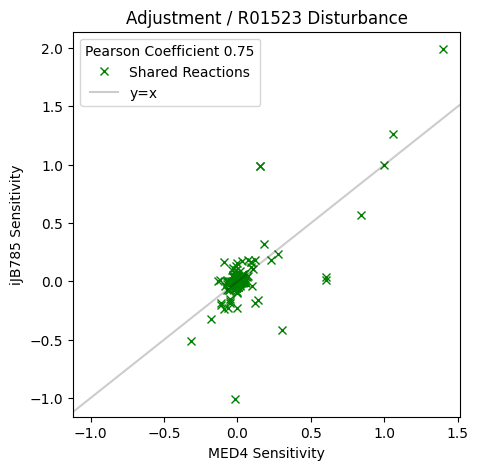

In [17]:
shared_rxns = list(elong_to_MED4.keys())

pruk = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
gapd = pd.DataFrame(index=shared_rxns, columns=['MED4', "iJB785"], dtype=float)
for rxn in shared_rxns:
    if rxn in ['GAPDi_nadp', 'PRUK']:
        continue
    else:
        pruk.loc[rxn, 'MED4'] = med4_sensitivities.loc[elong_to_MED4[rxn], 'R01523']
        pruk.loc[rxn, 'iJB785'] = elong_sensitivities.loc[rxn, 'PRUK']
        gapd.loc[rxn, 'MED4'] = med4_sensitivities.loc[elong_to_MED4[rxn], 'R01063']
        gapd.loc[rxn, 'iJB785'] = elong_sensitivities.loc[rxn, 'GAPDi_nadp']

pruk = pruk.dropna()
gapd = gapd.dropna()

rs = [scipy.stats.pearsonr(pruk['MED4'], pruk['iJB785']).statistic, scipy.stats.pearsonr(gapd['MED4'], gapd['iJB785']).statistic]
rxns = ['R01523', 'R01063']

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(pruk['MED4'], pruk['iJB785'], 'gx', label='Shared Reactions')
ax.axline((-1, -1), slope=1, label='y=x', color = 'k', alpha=0.2)
ax.legend(title=f'Pearson Coefficient {rs[0]:.2f}')
ax.set_title("Adjustment / R01523 Disturbance")
ax.set_xlabel("MED4 Sensitivity")
ax.set_ylabel("iJB785 Sensitivity")

plt.savefig("figures/CP12_sensitivity.png", dpi=1200)
plt.show()